### ДЗ №8 RNN

In [1]:
import pandas as pd
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [2]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_val = pd.read_csv("data/val.csv")

In [3]:
df_train.head(3)

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0


In [4]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

In [5]:
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [6]:
df_train.text.head(5)

0    alisachachkaич уезжаааааааать ❤ тожена хотеть ...
1    rt galyginvadim ребята девчата кино любовь зав...
2      rt artemklyushin ктоненавидеть пробка ретвит rt
3    rt epupybobv хотеться котлета покиевск запретн...
4    karinekurganova yessboss босапоп есбосан боять...
Name: text, dtype: object

In [7]:
# Чушь какая-то получается...
# Попробуем по-другому

In [8]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_val = pd.read_csv("data/val.csv")

In [9]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/postas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
def preprocess_text2(txt):
    txt = str(txt)
    tokens = [morpher.parse(token.lower())[0].normal_form for token in word_tokenize(txt) if token.isalpha() and token not in sw]
    return " ".join(tokens)

In [21]:
df_train['text'] = df_train['text'].apply(preprocess_text2)
df_val['text'] = df_val['text'].apply(preprocess_text2)
df_test['text'] = df_test['text'].apply(preprocess_text2)

In [22]:
df_train.text.head()

0           alisachachka уезжаааааааать хотеть уезжать
1    rt galyginvadim ребята девчата всё кино вот эт...
2                   rt кто ненавидеть пробка ретвит rt
3         rt epupybobv хотеться котлета запретный плод
4        karinekurganova босапоп есбосой бояться мороз
Name: text, dtype: object

In [24]:
# Что-то мне еще кажется, что стоп-слова здесь можно и оставить.. 
# Поскольку у нас будет обработка последовательности - то отбросив скажем слова "не"
# Мы теряем смысл таких сочетаний как "не уезжать" и тп.. не говоря уже о "не хороший", "не трудно" и так далее

In [11]:
def preprocess_text3(txt):
    txt = str(txt)
    tokens = [morpher.parse(token.lower())[0].normal_form for token in word_tokenize(txt) if token.isalpha()]
    return " ".join(tokens)

In [12]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_val = pd.read_csv("data/val.csv")

In [13]:
df_train['text'] = df_train['text'].apply(preprocess_text3)
df_val['text'] = df_val['text'].apply(preprocess_text3)
df_test['text'] = df_test['text'].apply(preprocess_text3)

In [14]:
df_train.text.head()

0    alisachachka не уезжаааааааать я тоже не хотет...
1    rt galyginvadim ребята и девчата всё в кино во...
2                   rt кто ненавидеть пробка ретвит rt
3         rt epupybobv хотеться котлета запретный плод
4    karinekurganova босапоп есбосой не бояться мор...
Name: text, dtype: object

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, LSTM, GRU, SimpleRNN, Masking, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard 
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping  
from tensorflow.keras.utils import to_categorical

In [16]:
text_corpus_train = df_train['text'].values
text_corpus_valid = df_val['text'].values
text_corpus_test = df_test['text'].values

In [17]:
text_corpus_train

array(['alisachachka не уезжаааааааать я тоже не хотеть чтобы ты уезжать',
       'rt galyginvadim ребята и девчата всё в кино вот это любовь сегодня завтра и потом вотэтолюбовь',
       'rt кто ненавидеть пробка ретвит rt', ...,
       'там длинный диагноз вкратце аллергический отечь горло с осложнение в вид фолликулярный ангина',
       'technoslav ух ты а кто тот серенький кнопочень телефон достаться',
       'я тоже так собираться сделать d навешать фотка вандюхий d обязательно выложить фотка как'],
      dtype=object)

In [18]:
tokenizer = Tokenizer(num_words=None, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

In [19]:
sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

In [20]:
sequences_train[:5]

[[30402, 2, 46850, 1, 68, 2, 26, 121, 11, 678],
 [5, 23107, 298, 3, 6244, 16, 4, 565, 33, 13, 259, 40, 66, 3, 114, 30403],
 [5, 48, 249, 746, 670, 5],
 [5, 46851, 125, 4889, 23108, 10712],
 [46852, 46853, 46854, 2, 236, 457, 3]]

In [21]:
word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in text_corpus_train])

In [22]:
word_count

123691

In [23]:
training_length

34

In [24]:
X_train = pad_sequences(sequences_train, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)

In [25]:
X_train[:3]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 30402,     2, 46850,
            1,    68,     2,    26,   121,    11,   678],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            5, 23107,   298,     3,  6244,    16,     4,   565,    33,
           13,   259,    40,    66,     3,   114, 30403],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     5,    48,   249,   746,   670,     5]], dtype=int32)

In [26]:
y_train = df_train['class'].values
y_val = df_val['class'].values

In [27]:
y_train[:5]

array([0, 1, 0, 1, 1])

In [50]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(SimpleRNN(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
early_stopping=EarlyStopping(monitor='val_loss')

In [52]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 15s 43ms/step - loss: 0.6102 - accuracy: 0.6357 - val_loss: 0.4756 - val_accuracy: 0.7666
Epoch 2/10
319/319 [==============================] - 13s 42ms/step - loss: 0.3775 - accuracy: 0.8345 - val_loss: 0.4926 - val_accuracy: 0.7651


In [53]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 0s 9ms/step - loss: 0.4984 - accuracy: 0.7637


Test score: 0.49844205379486084
Test accuracy: 0.7637437582015991


In [55]:
# Ну... как-то так.
# Перейдем к тяжелой артилерии LSTM

In [62]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(LSTM(64, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 34s 101ms/step - loss: 0.5957 - accuracy: 0.6654 - val_loss: 0.4687 - val_accuracy: 0.7680
Epoch 2/10
319/319 [==============================] - 30s 95ms/step - loss: 0.3996 - accuracy: 0.8217 - val_loss: 0.4808 - val_accuracy: 0.7663


In [63]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 1s 15ms/step - loss: 0.4823 - accuracy: 0.7668


Test score: 0.48234713077545166
Test accuracy: 0.7667856812477112


In [64]:
# Нууу... не сказать, что сильно лучше, но чуть-чуть повыше скор

In [65]:
# Попробуем еще bidirectional

In [67]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(Bidirectional(LSTM(64, recurrent_dropout=0.2)))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 55s 163ms/step - loss: 0.5891 - accuracy: 0.6721 - val_loss: 0.4712 - val_accuracy: 0.7655
Epoch 2/10
319/319 [==============================] - 52s 164ms/step - loss: 0.3941 - accuracy: 0.8232 - val_loss: 0.4856 - val_accuracy: 0.7689


In [68]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 1s 21ms/step - loss: 0.4933 - accuracy: 0.7679


Test score: 0.49330320954322815
Test accuracy: 0.7678878307342529


In [69]:
# Практически нет прироста, но по времени в два раза дольше...

In [70]:
# GRU

In [71]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(GRU(64, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 29s 86ms/step - loss: 0.5885 - accuracy: 0.6768 - val_loss: 0.4747 - val_accuracy: 0.7663
Epoch 2/10
319/319 [==============================] - 28s 89ms/step - loss: 0.3954 - accuracy: 0.8255 - val_loss: 0.4800 - val_accuracy: 0.7653


In [72]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 1s 15ms/step - loss: 0.4891 - accuracy: 0.7635


Test score: 0.4890536665916443
Test accuracy: 0.7635233402252197


In [73]:
# GRU по результативности на уровне SimpleRNN - а по скорости почти как LSTM :)) в нашем случае - смысла никакого

In [74]:
# Для сравнения CNN

In [28]:
model = Sequential()
model.add(Embedding(input_dim=word_count, output_dim=30, input_length=training_length))
model.add(Conv1D(30, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
2552/2552 [==============================] - 61s 22ms/step - loss: 0.5570 - accuracy: 0.6937 - val_loss: 0.4621 - val_accuracy: 0.7730
Epoch 2/10
2552/2552 [==============================] - 51s 20ms/step - loss: 0.3571 - accuracy: 0.8459 - val_loss: 0.4709 - val_accuracy: 0.7737


In [29]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 3s 35ms/step - loss: 0.4810 - accuracy: 0.7729


Test score: 0.4810042083263397
Test accuracy: 0.7729136347770691


In [30]:
# Ну... не знаю. Loss меньше, Accuracy - выше.. CNN - лучше в нашем случае.

In [30]:
# Еще попробуем сделать из нее чуть более RNN )) расширим размер кернела

In [31]:
model = Sequential()
model.add(Embedding(input_dim=word_count, output_dim=30, input_length=training_length))
model.add(Conv1D(30, 10))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
2552/2552 [==============================] - 60s 22ms/step - loss: 0.5539 - accuracy: 0.6974 - val_loss: 0.4575 - val_accuracy: 0.7759
Epoch 2/10
2552/2552 [==============================] - 52s 21ms/step - loss: 0.3340 - accuracy: 0.8575 - val_loss: 0.4676 - val_accuracy: 0.7740


In [32]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 3s 36ms/step - loss: 0.4736 - accuracy: 0.7753


Test score: 0.4735996723175049
Test accuracy: 0.7752501964569092


In [33]:
# Ну и уж размер эмбеддинга тоже ) (я понимаю, что это ломает чистоту эксперимента, просто в порядке исследования)

In [34]:
model = Sequential()
model.add(Embedding(input_dim=word_count, output_dim=128, input_length=training_length))
model.add(Conv1D(128, 10))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
2552/2552 [==============================] - 273s 105ms/step - loss: 0.5346 - accuracy: 0.7140 - val_loss: 0.4489 - val_accuracy: 0.7801
Epoch 2/10
2552/2552 [==============================] - 265s 104ms/step - loss: 0.2936 - accuracy: 0.8776 - val_loss: 0.4866 - val_accuracy: 0.7768


In [35]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 3s 38ms/step - loss: 0.4952 - accuracy: 0.7761


Test score: 0.4952062666416168
Test accuracy: 0.7760878205299377


In [36]:
# Оно того не стоит ))

In [38]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 3s 41ms/step - loss: 0.4742 - accuracy: 0.7749


Test score: 0.4742201864719391
Test accuracy: 0.7748975157737732


In [86]:
# Попробуем их скрестить еще )

In [93]:
model = Sequential()
model.add(Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Conv1D(128, 10))
model.add(Activation("relu"))

model.add(Masking(mask_value=0.0))
model.add(Bidirectional(LSTM(64, recurrent_dropout=0.2)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
2552/2552 [==============================] - 346s 133ms/step - loss: 0.5400 - accuracy: 0.7107 - val_loss: 0.4552 - val_accuracy: 0.7757
Epoch 2/10
2552/2552 [==============================] - 335s 131ms/step - loss: 0.3253 - accuracy: 0.8581 - val_loss: 0.4891 - val_accuracy: 0.7699


In [94]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 4s 55ms/step - loss: 0.4874 - accuracy: 0.7711


Test score: 0.48740848898887634
Test accuracy: 0.7710620164871216


In [95]:
# Не впечатлило... может я их готовить не умею просто ))

In [39]:
# Ну и для общего понимания - на какой мы земле - обычная полносвязная сеть

In [40]:
model = Sequential()
model.add(Embedding(input_dim=word_count, output_dim=128, input_length=training_length))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
2552/2552 [==============================] - 268s 105ms/step - loss: 0.6865 - accuracy: 0.5261 - val_loss: 0.6831 - val_accuracy: 0.5282
Epoch 2/10
2552/2552 [==============================] - 271s 106ms/step - loss: 0.6781 - accuracy: 0.5385 - val_loss: 0.6840 - val_accuracy: 0.5285


In [43]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 0s 7ms/step - loss: 0.6843 - accuracy: 0.5279


Test loss: 0.6842660307884216
Test accuracy: 0.5279465913772583


In [42]:
# Ну неет... понятно, что свертки и рнн гораздо мощнее в этой задаче

In [44]:
# Для очистки совести - еще наш древний бэйзлайн: tf/idf - LogReg

In [46]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [47]:
tfvectorizer = TfidfVectorizer(ngram_range=(1, 4), analyzer='char')

In [48]:
X_train_tf = tfvectorizer.fit_transform(df_train.text)
X_val_tf = tfvectorizer.transform(df_val.text)
X_train_tf.shape

(181467, 269876)

In [50]:
%%time
lr = LogisticRegression(random_state=42, max_iter=256)
lr.fit(X_train_tf, y_train)

CPU times: user 2min 11s, sys: 3min 1s, total: 5min 13s
Wall time: 25.8 s


LogisticRegression(max_iter=256, random_state=42)

In [51]:
pred_tf = lr.predict(X_val_tf)

In [52]:
accuracy_score(y_val, pred_tf)

0.7682405325574219

In [54]:
# А вот TF/IDF + LogReg кстати лучше RNN работает в этой задачке.

In [80]:
# Попробуем свести все воедино.. (жаль не сохранял в какой нибудь список измерения)
scores = [0.7637437582015991, 0.7667856812477112, 0.7678878307342529, 0.7635233402252197, 0.7729136347770691,
          0.7752501964569092, 0.5279465913772583, 0.7682405325574219]
labels = ['SimpleRNN', 'LSTM', 'BiDir_LSTM', 'GRU', 'CNN', 'WIDE_CNN', 'FCNN', 'LOGREG']

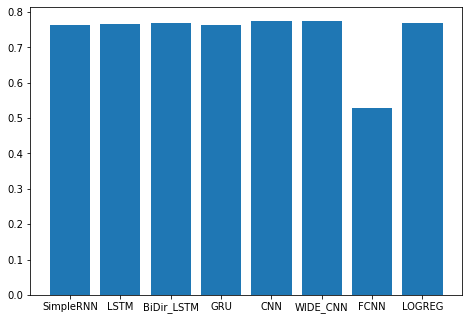

In [73]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels, scores)
plt.show()

In [82]:
# Не особо наглядно )))
# Надо выкинуть отсюда аутсайдера
scores_clean = scores[:6] + [scores[-1]]
labels_clean = labels[:6] + [labels[-1]]

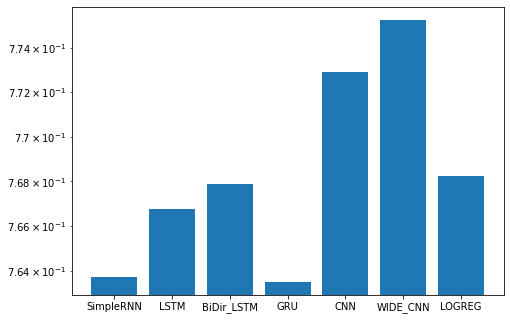

In [84]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_yscale('log')
ax.bar(labels_clean, scores_clean)
plt.show()

In [85]:
# Как-то так...

In [75]:
result = pd.DataFrame(zip(labels, scores))

In [76]:
result

,0,1
0,SimpleRNN,0.763744
1,LSTM,0.766786
2,BiDir_LSTM,0.767888
3,GRU,0.763523
4,CNN,0.772914
5,WIDE_CNN,0.775250
6,FCNN,0.527947
7,LOGREG,0.768241


### Вобщем
Понятно, что не было особо экспериментов с архитектурами, но в целом при прочих равных, я бы выбрал TF/IDF+LogReg.. Она ГОРАЗДО быстрее всего остального, проигрывая меньше 1% тяжелым сверткам, на обучение которых нужно много времени.
RNN - впринципе на уровне - но ничего прорывного )